## This Notebook applys the algorithm 1 in Ahlfeldt et. al (2024) to numerically invert Quality of Life.

In [1]:
using LinearAlgebra, DataFrames
using CSV
using Plots
using Colors

#### The setting of structral parameters are the same to the paper.

In [2]:
α = 0.7;
β = 0.3419;  
ξ = 5.5; 
γ = 3;
κ = 0.2;

In [3]:
df = DataFrame(CSV.File("ABRSQOL-testdata.csv"))

Row,llm_id,w,p_H,P_t,p_n,L,L_b,Name,coord_x,coord_y
,Int64,Float64,Float64,Int64,Int64,Int64,Int64,String31,Float64,Float64
1,1,1975.34,2134.22,1,1,724185,689304,Kiel,5.73647e5,6.02024e6
2,2,1971.55,2032.82,1,1,415827,405739,Lübeck,6.13573e5,5.97072e6
3,3,1707.19,1249.22,1,1,132917,129407,Dithmarschen,5.0857e5,5.97364e6
4,4,1939.47,1853.3,1,1,446741,431290,Flensburg,5.28196e5,6.07095e6
5,5,2203.35,5304.53,1,1,3355293,2871439,Hamburg,5.92262e5,5.92118e6
6,6,2007.01,2249.25,1,1,605744,583675,Braunschweig,6.0399e5,5.79275e6
7,7,1995.25,2051.38,1,1,389750,346259,Wolfsburg,6.21411e5,5.80822e6
8,8,1709.41,1233.31,1,1,565759,618843,Göttingen,5.71647e5,5.74859e6
9,9,1714.29,885.13,1,1,359602,459466,Goslar,6.07905e5,5.75e6


Here I normalize the hometown population to make sure that 
$$
\bar{L}=\sum_{i \in J} L_i=\sum_{i \in J} \bar{L}_i^b
$$

In [4]:
L_bar = sum(df.L);
L_bar_b = sum(df.L_b);
L_b = L_bar/L_bar_b .* df.L_b;
L_hat = df.L ./ df.L[1];

Then I calculate the relative values of variables w.r.t. the first location (Kiel here as the numeraire).
$$
\hat{\mathcal{V}}=\left\{\hat{L}, \hat{\bar{L}}^b, \hat{p}^H, \hat{p}^n, \hat{P}^t, \hat{w}\right\}
$$

In [5]:
P_t = df.P_t;
p_n = df.p_n;
p_H = df.p_H;
w = df.w;
p_t_hat = P_t ./ P_t[1];
p_n_hat = p_n ./ p_n[1];
p_H_hat = p_H ./ p_H[1];
w_hat = w / w[1];

Solve for the aggregate consumer price index and the corresponding relative one
$$
P_i \equiv\left(P_i^t\right)^{\alpha \beta}\left(p_i^n\right)^{\alpha(1-\beta)}\left(p_i^H\right)^{1-\alpha}\\
\hat{P_i} \equiv \left(\hat{P}^t\right)^{\alpha \beta}\left(\hat{p}^n\right)^{\alpha(1-\beta)}\left(\hat{p}^H\right)^{1-\alpha}
$$

In [6]:
p_hat = p_t_hat .^(α*β) .* p_n_hat .^(α * (1-β)) .* p_H_hat.^(1-α);
p = P_t .^(α*β) .* p_n .^(α * (1-β)) .* p_H.^(1-α);

Here I generate the initial guess of $A = (1,1,...,1)$

In [7]:
A = ones(size(w));

Set the tolerance and max interation.

In [8]:
eps = 1000
max_int = 100000
tol = 1e-14
count_num = 0;

The procedure is as following:

(1) Solve for $\Psi_i^b$
$$
\Psi_i^b=\left(1+\frac{(\exp [\xi]-1)\left(A_i w_i / \mathcal{P}_i\right)^\gamma}{\sum_{j \in J}\left(A_j w_j / \mathcal{P}_j\right)^\gamma}\right)^{-1}
$$
(2) Solve for $\mathcal{L}$
$$
\mathcal{L}_i \equiv(\exp [\xi]-1) \Psi_i^b \bar{L}_i^b+\sum_{m \in J} \Psi_m^b \bar{L}_m^b
$$
(3) Calculate relative value of $\mathcal{L}$ as $\hat{\mathcal{L}}$
(4) Invert $\hat{A_{new}}$ by 
$$
\hat{A}=\frac{\left(\hat{P}^t\right)^{\alpha \beta}\left(\hat{p}^n\right)^{\alpha(1-\beta)}\left(\hat{p}^H\right)^{1-\alpha}}{\hat{w}}(\hat{L} / \hat{\mathcal{L}})^{\frac{1}{\gamma}}
$$
(5) Check convergence.

(6) If *eps* is larger that the tolerance, I update the value of $A$ and start from (1):
$$
\hat{A}=\kappa \cdot \hat{A}^{\text {new }}+(1-\kappa) \cdot \hat{A}
$$
(7) $\hat{A}$ converges.



In [9]:
while eps >= tol && count_num <= max_int
    deno = sum((A .* w ./ p).^(γ))
    Ψ = (1 .+ (exp(ξ)-1).*(A.*w ./p).^γ ./ deno ).^(-1);
    L_mathcal = Ψ' * L_b.+ (exp(ξ) -1) .* Ψ .* L_b;
    L_mathcal_hat = L_mathcal ./ L_mathcal[1];
    A_hat = p_hat ./ w_hat .* (L_hat ./ L_mathcal_hat) .^(1/γ)
    eps = maximum(abs.((A- A_hat)))
    A = κ .* A_hat + (1-κ) .* A
    count_num  = count_num + 1
end

In [10]:
RRQOL = p_H.^0.3 ./ w;
RRQOL_hat = RRQOL ./ RRQOL[1];
L_normalized = 10 .* (df.L .- minimum(df.L)) ./ (maximum(df.L) - minimum(df.L)) .+ 2;
Name = df.Name;

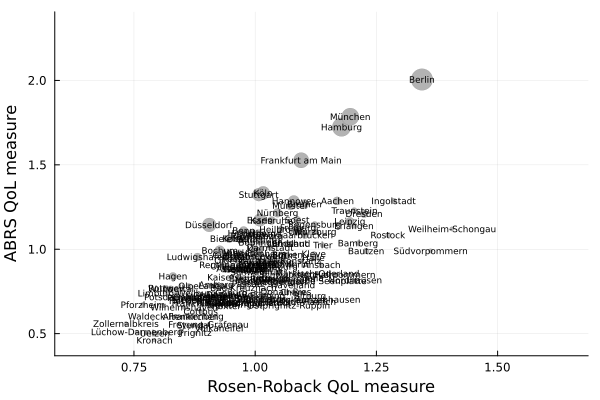

In [11]:
scatter(
    RRQOL_hat, A, 
    markersize = L_normalized,
    markercolor = RGB(0.7, 0.7, 0.7),
    markerstrokecolor = :black,
    markerstrokewidth = 0.1,
    label = false,
    xlabel = "Rosen-Roback QoL measure",
    ylabel = "ABRS QoL measure",
    background_color = :white,
)
for i in 1:length(A)
    annotate!(RRQOL_hat[i], A[i], text(Name[i], 6, :black, halign=:center))
end
xlims!(minimum(RRQOL_hat)*0.8, maximum(RRQOL_hat)*1.2)
ylims!(minimum(A)*0.8, maximum(A)*1.2)
display(current())